In [65]:
import numpy as np
import matplotlib.pyplot as plt
import dill
import pandas as pd
import os, sys
sys.path.append('../')
import mg_si
%matplotlib inline
from matplotlib import gridspec
import matplotlib as mpl
# import seaborn


In [2]:
Myrs = 365.25*24*3600*1e6
Cent = 1e6

def compute_entropies(pl, times, solution, N_approx=1000):
    allp = mg_si.base.Parameters('entropies')
    Nt = len(times)
    di = int((len(times)-1)//N_approx)
    N = np.min((Nt // di, (Nt - 1) // di))
    allp.Er = np.empty(N)
    allp.Egm = np.empty(N)
    allp.Egs = np.empty(N)
    allp.Egf = np.empty(N)
    allp.Eg = np.empty(N)
    allp.Es = np.empty(N)
    allp.El = np.empty(N)
    allp.Ek = np.empty(N)
    allp.DE = np.empty(N)
    allp.Ephi = np.empty(N)
    sol_N = (solution[::di,:])[:N,:]
    t_N = times[::di][:N]
    allp.dTcmb = (np.diff(solution[:,0]) / np.diff(times))[::di][:N]
    for i, t, T, dT, Tm in zip(range(N), t_N, sol_N[:,0], allp.dTcmb, sol_N[:,1]):
        Moles = sol_N[i, 2:]
        h = pl.core_layer.heat_production_per_kg(t)
        pl.core_layer.reset_current_values()
        allp.Er[i] = (pl.core_layer.E_R(T, h, recompute=False))
        allp.Egm[i] = (pl.core_layer.E_gm(T, dT, Moles, time=t, recompute=False))
        allp.Egs[i] = (pl.core_layer.E_gs(T, dT, Moles, time=t, recompute=False))
        allp.Egf[i] = (pl.core_layer.E_gf(T, dT, Moles, time=t, recompute=False))
        allp.Eg[i] = (pl.core_layer.E_g(T, dT, recompute=False))
        allp.Es[i] = (pl.core_layer.E_s(T, dT, recompute=False))
        allp.El[i] = (pl.core_layer.E_L(T, dT, recompute=False))
        allp.Ek[i] = (pl.core_layer.E_k(recompute=False))
        allp.DE[i] = (pl.core_layer.Delta_E(T, dT, h, Moles, time=t, recompute=False))
        allp.Ephi[i] = (pl.core_layer.E_phi(T, dT, h, Moles, time=t, recompute=False))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
    return t_N, allp

def compute_and_save_entropies(base_dir):
    dirs = list(os.walk(base_dir))
    all_entropies = []
    for dirname in dirs[1:]:
        entfile = dirname[0]+'/entropies.m'
        if os.path.isfile(entfile):
            t_N, ents = dill.load(open(entfile,'rb'))
        else:
            pl, t, solution = dill.load(open(dirname[0]+'/data.m','rb'))
            t_N, ents = compute_entropies(pl,t,solution)
            dill.dump((t_N, ents), open(entfile,'wb'))
        all_entropies.append((t_N, ents, dirname[0]))
    return all_entropies


In [46]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
def smooth(x,N=3):
    assert(N%2==1)
    out = np.array(x)
    out[(N-1)//2:-(N-1)//2] = running_mean(x,N)
    return out
def replace_outliers(y, percent=0.2, N=3):
    assert(N%2==1)
    Nends = N-1
    outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) > percent)[0]+1
    y2 = np.array(y)
    y2[outliers] = 0.
    for n in range(1,Nends//2+1):
        y2[outliers] += (y[outliers-n]+y[outliers+n])/Nends
    return y2
def remove_outliers(t,y,percent=0.2, N=3):
    Nends = N-1
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(2*y[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

In [47]:
def get_all_wtp(base_dir):
    dirs = list(os.walk(base_dir))
    all_wtp = np.zeros((len(dirs)-1,4))
    for i,dirname in enumerate(dirs[1:]):
        pl, t, solution = dill.load(open(dirname[0]+'/data.m','rb'))
        all_wtp[i,:] = pl.reactions.core.M2wtp(solution[-1,2:6])
    return all_wtp


In [5]:
all_wtp = get_all_wtp('../valid_results_1/')

In [6]:
wtp_plt = np.zeros_like(all_wtp)
wtp_plt[:,0:2] = all_wtp[:,0:2]
wtp_plt[:,2] = all_wtp[:,3]
wtp_plt[:,3] = np.sum(wtp_plt[:,:3],axis=-1)
columns = ['Mg','Si','O','total']
df = pd.DataFrame(data=wtp_plt*100, columns=columns)

In [7]:
all_ents = compute_and_save_entropies('../valid_results_1/')


In [55]:

def load_all_data_nature(basedir, csvfile, alldatafile='all_parameters.m'):
    all_data = []
    column_names = ['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn']
    df10 = pd.read_csv(basedir+datafile, names=column_names)
    N = len(df10)
    for i,row in df10.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+alldatafile):
            continue
        t_N, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        all_data.append((t_N, allp, foldername))
    return all_data

In [56]:
# csvfile = 'ri10p_data.csv'
csvfile = 'ri05p_data.csv'

alldatafile = 'all_parameters.m'
basedir = '../computed_solutions_nature/'
all_ents = load_all_data_nature(basedir, csvfile, alldatafile=alldatafile)

In [57]:

fcolor = '#e41a1c'
fscolor = '#ff7f00'
mcolor = '#377eb8'
mscolor = '#984ea3'
scolor = '#4daf4a'
ocolor = '#ffff99'
iccolor = '#a65628'

/home/nknezek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


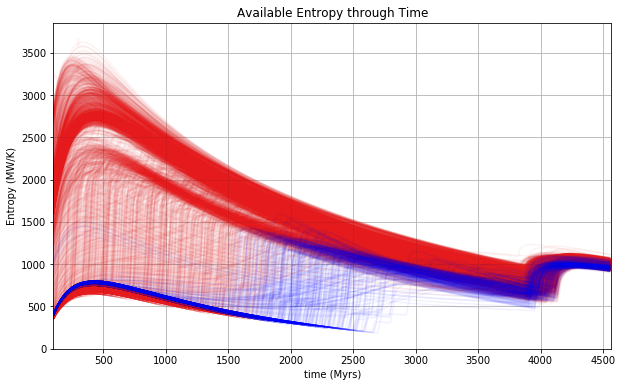

In [58]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
plt.figure(figsize=(10,6))
for t_plt, params,_ in all_ents:
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
    elif Esit > Efet and Esit>Emgt:
        color = scolor
    else:
        color = 'black'
    tp, ep = remove_outliers(t_plt/Myrs,params.Ephi/Cent, percent=0.05, N=5)
    plt.plot(tp,ep, '-',color=color, alpha=0.05)
#     plt.plot(t_plt/Myrs, params.Ephi/Cent, '.',color='black', alpha=0.3)

plt.ylim(0,)
plt.xlim(100,4.568e3)
plt.xlabel('time (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('Available Entropy through Time')
plt.grid()
# plt.savefig('Entropy_time.pdf')

/home/nknezek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


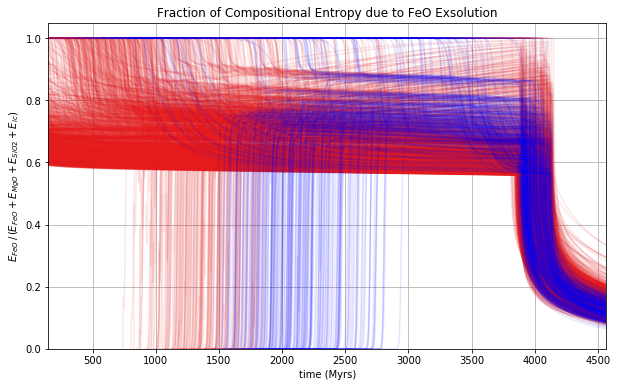

In [61]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
plt.figure(figsize=(10,6))
for t_plt, params,_ in all_ents:
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
    elif Esit > Efet and Esit>Emgt:
        color = scolor
    else:
        color = 'black'
    
    numer = params.Egf
    denom = (params.Eic+params.Eex)
    Ef_frac = np.divide(numer, denom, out=np.ones_like(numer)*np.nan, where=denom!=0.)
    plt.plot(t_plt/Myrs, Ef_frac, color=color, alpha=0.1)
    
plt.ylim(0,)
plt.xlim(150,4.568e3)
plt.xlabel('time (Myrs)')
plt.ylabel(r'$E_{FeO} \,/\, (E_{FeO} + E_{MgO} + E_{SiO2} + E_{ic})$')
plt.title('Fraction of Compositional Entropy due to FeO Exsolution')
plt.grid()
# plt.savefig('Entropy_frac_FeO.pdf')

/home/nknezek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


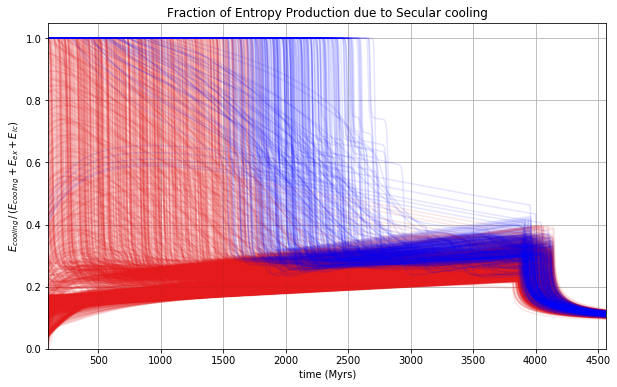

In [62]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
plt.figure(figsize=(10,6))
for t_plt, params,_ in all_ents:
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
    elif Esit > Efet and Esit>Emgt:
        color = scolor
    else:
        color = 'black'
    
    Es_frac = params.Es/(params.Es+params.Eic+params.Eex)
    plt.plot(t_plt/Myrs, Es_frac, color=color, alpha=0.1)
    
plt.ylim(0,)
plt.xlim(100,4.568e3)
plt.xlabel('time (Myrs)')
plt.ylabel(r'$E_{cooling} \,/\, (E_{cooling} + E_{ex} + E_{ic})$')
plt.title('Fraction of Entropy Production due to Secular cooling')
plt.grid()
# plt.savefig('Entropy_frac_cooling.pdf')

/home/nknezek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


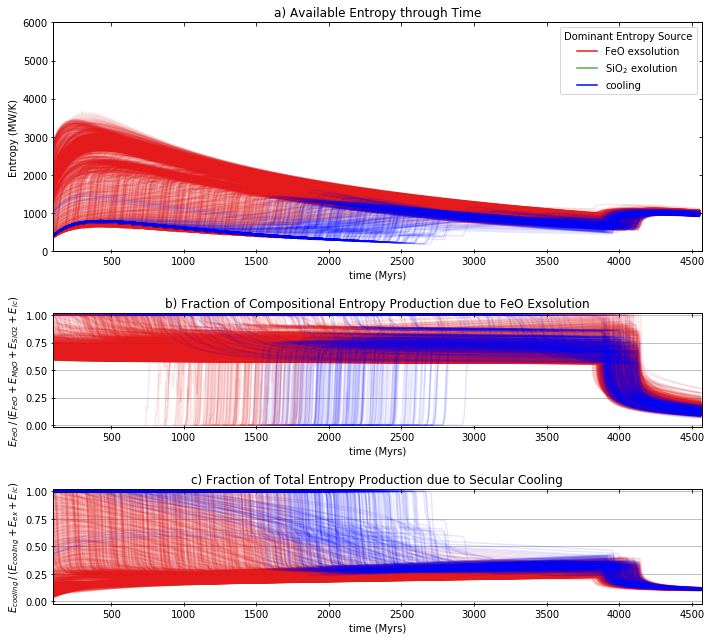

In [66]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.1
plt.figure(figsize=(10,9))
gs = gridspec.GridSpec(3, 1, height_ratios=[2,1,1]) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
for t_plt, params,_ in all_ents:
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
    elif Esit > Efet and Esit>Emgt:
        color = scolor
    else:
        color = 'black'
    colors.append(color)
    tp, ep = remove_outliers(t_plt/Myrs,params.Ephi/Cent, percent=0.05, N=5)
    plt.plot(tp,ep, '-',color=color, alpha=alpha)

fline = mpl.lines.Line2D([],[],color=fcolor)
sline = mpl.lines.Line2D([],[],color=scolor)
coolline = mpl.lines.Line2D([],[],color='blue')
plt.legend(loc='upper right',handles=[fline,sline,coolline],labels=['FeO exsolution','SiO$_2$ exolution','cooling'], title='Dominant Entropy Source')
plt.ylim(0,6000)
plt.xlim(100,4.568e3)
plt.xlabel('time (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())


ax = plt.subplot(gs[1])
for i,(t_plt, params,_) in enumerate(all_ents):
    numer = params.Egf
    denom = (params.Eic+params.Eex)
    Ef_frac = np.divide(numer, denom, out=np.ones_like(numer)*np.nan, where=denom!=0.)
    plt.plot(t_plt/Myrs, Ef_frac, color=colors[i], alpha=alpha)
    
ep = 0.02
plt.ylim(0-ep,1+ep)
plt.xlim(100,4.568e3)
plt.xlabel('time (Myrs)')
plt.ylabel(r'$E_{FeO} \,/\, (E_{FeO} + E_{MgO} + E_{SiO2} + E_{ic})$')
plt.title('b) Fraction of Compositional Entropy Production due to FeO Exsolution')
plt.grid(axis='y')
axt = ax.twiny()
# axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
# axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
# axr.set_yticklabels([])
# axr.set_ylim(ax.get_ylim())
# axr.set_yticks(ax.get_yticks())

ax = plt.subplot(gs[2])
for i,(t_plt, params,_) in enumerate(all_ents):
    Es_frac = params.Es/(params.Es+params.Eic+params.Eex)
    plt.plot(t_plt/Myrs, Es_frac, color=colors[i], alpha=alpha)    
plt.ylim(0-ep,1+ep)
plt.xlim(100,4.568e3)
plt.xlabel('time (Myrs)')
plt.ylabel(r'$E_{cooling} \,/\, (E_{cooling} + E_{ex} + E_{ic})$')
plt.title('c) Fraction of Total Entropy Production due to Secular Cooling')
plt.grid(axis='y')
axt = ax.twiny()
# axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
# axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
# axr.set_yticklabels([])
# axr.set_ylim(ax.get_ylim())
# axr.set_yticks(ax.get_yticks())

plt.tight_layout()
plt.savefig('figure3_colors_r05.pdf')

# Find Inner Core Nucleation

In [9]:
def compute_and_save_ic_nucleation(base_dir, recompute=False, dt0=1, dt1=100):
    dirs = list(os.walk(base_dir))
    t_ic_nucleation = []
    i_ic_nucleation = []
    dEps = []
    for dirname in dirs[1:]:
        icfile = dirname[0]+'/icnucleation.m'
        if os.path.isfile(icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(icfile,'rb'))
        else:
            pl, t, solution = dill.load(open(dirname[0]+'/data.m','rb'))
            t_ic, i_ic = find_ic_nucleation(pl,t,solution,Napprox=4568)
            dEp = ent_jump_ic_nuc(pl,t,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(icfile,'wb'))
        t_ic_nucleation.append(t_ic)
        i_ic_nucleation.append(i_ic)
        dEps.append(dEp)
    return t_ic_nucleation, i_ic_nucleation, dEps

def find_ic_nucleation(pl,t,solution, Napprox=10000):
    di = max(1,int(len(t)/Napprox))
    i = 0
    Tc = solution[:,0]
    found = False
    while(found==False):        
        if i*di > len(Tc):
            return np.nan, np.nan
        r_t = pl.core_layer.r_i(Tc[i*di], one_off=True)
        i+=1     
        if r_t > 0.:
            found = True
    return t[i*di], i*di

def compute_Ephi(pl,t,solution,ind):
    Tc = solution[ind,0]
    dTdt = (solution[ind+1,0]-solution[ind,0])/(t[ind+1]-t[ind])
    h = pl.core_layer.heat_production_per_kg(t[ind])    
    E_phi = pl.core_layer.E_phi(Tc, dTdt, h, solution[ind,2:], time=t[ind],recompute=True, store_computed=False)
    return E_phi

def ent_jump_ic_nuc(pl,t,solution,ind_icn, return_percent=True, return_raw=False, dt0=1, dt1=100):
    dt = t[ind_icn+1] - t[ind_icn]
    i0 = ind_icn - int(dt0*Myrs/dt)
    i1 = ind_icn + int(dt1*Myrs/dt)
    Ephi0 = compute_Ephi(pl,t,solution, i0)
    Ephi1 = compute_Ephi(pl,t,solution, i1)
    if return_percent:
        return (Ephi1-Ephi0)/Ephi0
    elif return_raw:
        return Ephi0, Ephi1
    else:
        return Ephi1-Ephi0
    

In [10]:
# find inner core nucleation time
t_ics, i_ics, dEps = compute_and_save_ic_nucleation('../valid_results_1/')

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


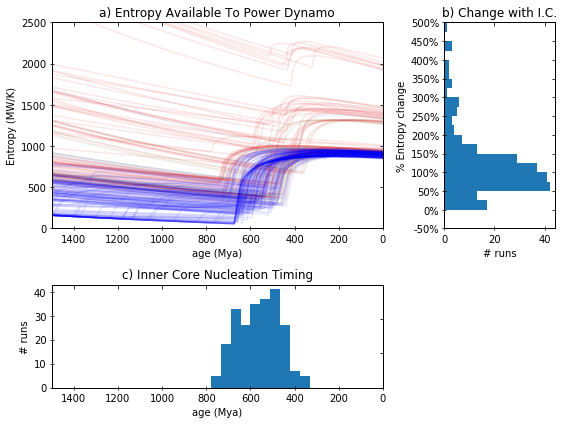

In [248]:
t_ic_c = []
i_ic_c = []
t_ic_ex = []
i_ic_ex = []

plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[2,1]) 
t_start = 1500
ax = plt.subplot(gs[0])
for i,(t_plt, params,_) in enumerate(all_ents):
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
        t_ic_c.append(t_ics[i])
        i_ic_c.append(i_ics[i])
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
    elif Esit > Efet and Esit>Emgt:
        color = scolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
    else:
        color = 'black'
    
    tp, ep = remove_outliers(t_plt/Myrs,params.Ephi/Cent, percent=0.05, N=5)
    plt.plot((tp[-1]-tp), ep, color=color, alpha=0.1)
plt.ylim(0,2500)
plt.xlim(t_start,0)
plt.xlabel('age (Mya)')
plt.ylabel('Entropy (MW/K)')
plt.title("a) Entropy Available To Power Dynamo")
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax = plt.subplot(gs[1])
bb = -25
bt = 600
bins=np.linspace(bb,bt,(bt-bb)/25+1)
plt.hist([(x)*100 for x in dEps],bins=bins, orientation="horizontal")
ymin = -50
ymax = 500
plt.ylim(ymin,ymax)
yticks = np.linspace(ymin,ymax,int((ymax-ymin)//50+1))
plt.yticks(yticks, ['{:.0f}%'.format(x) for x in yticks])
plt.xlabel('# runs')
plt.ylabel('% Entropy change')
plt.title("b) Change with I.C.")
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())


ax = plt.subplot(gs[2])
plt.hist(((t_plt[-1]-t_ics)/Myrs))
plt.xlim(t_start,0)
plt.xlabel('age (Mya)')
plt.ylabel('# runs')
plt.title('c) Inner Core Nucleation Timing')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
plt.tight_layout()
plt.savefig('figure4.pdf')

# Version splitting out exsolution vs not

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


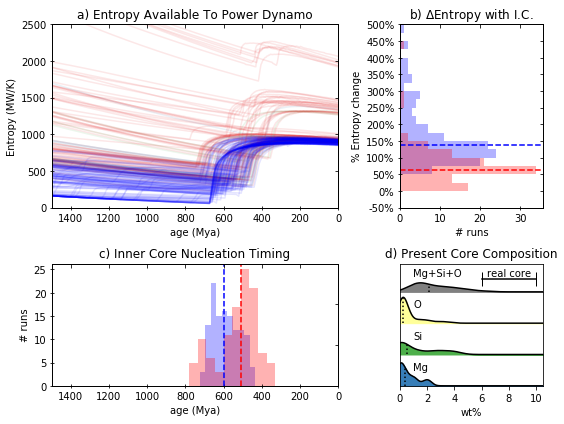

In [112]:
t_ic_c = []
i_ic_c = []
t_ic_ex = []
i_ic_ex = []
dEps_ex = []
dEps_c = []

plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1.5,1]) 
t_start = 1500
ax = plt.subplot(gs[0])
for i,(t_plt, params,_) in enumerate(all_ents):
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
        t_ic_c.append(t_ics[i])
        i_ic_c.append(i_ics[i])
        dEps_c.append(dEps[i])
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
        dEps_ex.append(dEps[i])
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
        dEps_ex.append(dEps[i])
    elif Esit > Efet and Esit>Emgt:
        color = scolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
        dEps_ex.append(dEps[i])
    else:
        color = 'black'
    
    tp, ep = remove_outliers(t_plt/Myrs,params.Ephi/Cent, percent=0.05, N=5)
    plt.plot((tp[-1]-tp), ep, color=color, alpha=0.1)
plt.ylim(0,2500)
plt.xlim(t_start,0)
plt.xlabel('age (Mya)')
plt.ylabel('Entropy (MW/K)')
plt.title("a) Entropy Available To Power Dynamo")
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax = plt.subplot(gs[1])
bb = -25
bt = 600
bins=np.linspace(bb,bt,(bt-bb)/25+1)
plt.hist([(x)*100 for x in dEps_c],bins=bins, orientation="horizontal", color='blue', alpha=0.3)
plt.hist([(x)*100 for x in dEps_ex],bins=bins, orientation="horizontal", color='red', alpha=0.3)
xlims = plt.xlim()
plt.hlines(np.median(dEps_c)*100, xlims[0], xlims[1], linestyles='--',color='blue')
plt.hlines(np.median(dEps_ex)*100, xlims[0], xlims[1], linestyles='--',color='red')
plt.xlim(xlims)
ymin = -50
ymax = 500
plt.ylim(ymin,ymax)
yticks = np.linspace(ymin,ymax,int((ymax-ymin)//50+1))
plt.yticks(yticks, ['{:.0f}%'.format(x) for x in yticks])
plt.xlabel('# runs')
plt.ylabel('% Entropy change')
plt.title("b) $\Delta$Entropy with I.C.")
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())


ax = plt.subplot(gs[2])
plt.hist(((t_plt[-1]-t_ic_c)/Myrs), color='blue', alpha=0.3)
plt.hist(((t_plt[-1]-t_ic_ex)/Myrs), color='red', alpha=0.3)
ylims = plt.ylim()
plt.vlines(np.median((t_plt[-1]-t_ic_c)/Myrs), ylims[0], ylims[1], linestyles='--',color='blue')
plt.vlines(np.median((t_plt[-1]-t_ic_ex)/Myrs), ylims[0], ylims[1], linestyles='--',color='red')
plt.ylim(ylims)
plt.xlim(t_start,0)
plt.xlabel('age (Mya)')
plt.ylabel('# runs')
plt.title('c) Inner Core Nucleation Timing')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax = plt.subplot(gs[3])
xmax=10.5
x_range = np.linspace(0,xmax,1000)
colors = [mcolor,scolor,ocolor,'grey']
for i,name in enumerate(['Mg','Si','O','total']):
    gkde = gaussian_kde(df[name],bw_method=.4)
    y = gkde.evaluate(x_range)
#     y = y/np.max(y)
    med = np.median(df[name])
    plt.plot([med]*2,[i,i+gkde.evaluate(med)],':k')
    plt.fill_between(x_range, i, y+i, clip_on=True, color=colors[i])
    plt.plot(x_range, i+y,'k')
fsize = 10
plt.text(1,0.5,'Mg', fontsize=fsize)
plt.text(1,1+0.5,'Si', fontsize=fsize)
plt.text(1,2+0.5,'O', fontsize=fsize)
plt.text(1,3+0.5,'Mg+Si+O', fontsize=fsize)

plt.plot([6,10],[3.4]*2,'|-k', markersize=14)
plt.text(6.4,3.5,'real core', fontsize=fsize)
# plt.yticks(np.array([0,1,2,3])+.1,['Mg','Si','O','Mg+Si+O'])
plt.yticks([])
ax.tick_params(left=False)
plt.title('d) Present Core Composition')
plt.xlim(0,xmax)
plt.ylim(0,3.9)
plt.xlabel('wt%')
plt.xticks(np.linspace(0,10,6))
# plt.savefig('light_elements_rough.pdf')

plt.tight_layout()
plt.savefig('figure4_dense.pdf')

In [20]:
import joypy
from scipy.stats import gaussian_kde

(0, 3.8)

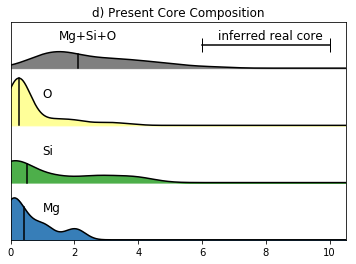

In [93]:
xmax=10.5
x_range = np.linspace(0,xmax,1000)
colors = [mcolor,scolor,ocolor,'grey']
plt.figure()
ax = plt.subplot(111)
for i,name in enumerate(['Mg','Si','O','total']):
    gkde = gaussian_kde(df[name],bw_method=.4)
    y = gkde.evaluate(x_range)
#     y = y/np.max(y)
    med = np.median(df[name])
    plt.plot([med]*2,[i,i+gkde.evaluate(med)],'k')
    plt.fill_between(x_range, i, y+i, clip_on=True, color=colors[i])
    plt.plot(x_range, i+y,'k')
fsize = 12
plt.text(1,0.5,'Mg', fontsize=fsize)
plt.text(1,1+0.5,'Si', fontsize=fsize)
plt.text(1,2+0.5,'O', fontsize=fsize)
plt.text(1.5,3+0.5,'Mg+Si+O', fontsize=fsize)

plt.plot([6,10],[3.4]*2,'|-k', markersize=14)
plt.text(6.5,3.5,'inferred real core', fontsize=fsize)
# plt.yticks(np.array([0,1,2,3])+.1,['Mg','Si','O','Mg+Si+O'])
plt.yticks([])
ax.tick_params(left=False)
plt.title('d) Present Core Composition')
plt.xlim(0,xmax)
plt.ylim(0,3.8)

(<Figure size 432x288 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11928e278>])

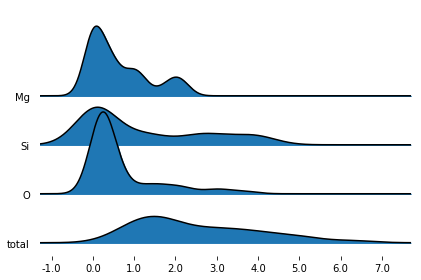

In [50]:
joypy.joyplot(df)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


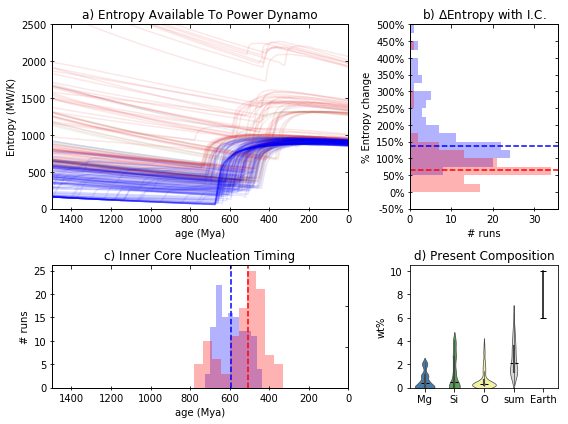

In [21]:
t_ic_c = []
i_ic_c = []
t_ic_ex = []
i_ic_ex = []
dEps_ex = []
dEps_c = []

plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1.5,1]) 
t_start = 1500
ax = plt.subplot(gs[0])
for i,(t_plt, params,_) in enumerate(all_ents):
    Efet = np.sum(params.Egf)
    Emgt = np.sum(params.Egm)
    Esit = np.sum(params.Egs)
    Est = np.sum(params.Es)
    Eext = Efet+Emgt+Esit
    if Est > Eext:
        color='blue'
        t_ic_c.append(t_ics[i])
        i_ic_c.append(i_ics[i])
        dEps_c.append(dEps[i])
    elif Efet > Emgt and Efet>Esit:
        color=fcolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
        dEps_ex.append(dEps[i])
    elif Emgt > Esit and Emgt>Esit:
        color = mcolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
        dEps_ex.append(dEps[i])
    elif Esit > Efet and Esit>Emgt:
        color = scolor
        t_ic_ex.append(t_ics[i])
        i_ic_ex.append(i_ics[i])
        dEps_ex.append(dEps[i])
    else:
        color = 'black'
    
    tp, ep = remove_outliers(t_plt/Myrs,params.Ephi/Cent, percent=0.05, N=5)
    plt.plot((tp[-1]-tp), ep, color=color, alpha=0.1)
plt.ylim(0,2500)
plt.xlim(t_start,0)
plt.xlabel('age (Mya)')
plt.ylabel('Entropy (MW/K)')
plt.title("a) Entropy Available To Power Dynamo")
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax = plt.subplot(gs[1])
bb = -25
bt = 600
bins=np.linspace(bb,bt,(bt-bb)/25+1)
plt.hist([(x)*100 for x in dEps_c],bins=bins, orientation="horizontal", color='blue', alpha=0.3)
plt.hist([(x)*100 for x in dEps_ex],bins=bins, orientation="horizontal", color='red', alpha=0.3)
xlims = plt.xlim()
plt.hlines(np.median(dEps_c)*100, xlims[0], xlims[1], linestyles='--',color='blue')
plt.hlines(np.median(dEps_ex)*100, xlims[0], xlims[1], linestyles='--',color='red')
plt.xlim(xlims)
ymin = -50
ymax = 500
plt.ylim(ymin,ymax)
yticks = np.linspace(ymin,ymax,int((ymax-ymin)//50+1))
plt.yticks(yticks, ['{:.0f}%'.format(x) for x in yticks])
plt.xlabel('# runs')
plt.ylabel('% Entropy change')
plt.title("b) $\Delta$Entropy with I.C.")
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())


ax = plt.subplot(gs[2])
plt.hist(((t_plt[-1]-t_ic_c)/Myrs), color='blue', alpha=0.3)
plt.hist(((t_plt[-1]-t_ic_ex)/Myrs), color='red', alpha=0.3)
ylims = plt.ylim()
plt.vlines(np.median((t_plt[-1]-t_ic_c)/Myrs), ylims[0], ylims[1], linestyles='--',color='blue')
plt.vlines(np.median((t_plt[-1]-t_ic_ex)/Myrs), ylims[0], ylims[1], linestyles='--',color='red')
plt.ylim(ylims)
plt.xlim(t_start,0)
plt.xlabel('age (Mya)')
plt.ylabel('# runs')
plt.title('c) Inner Core Nucleation Timing')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax = plt.subplot(gs[3])
ylabel = 'wt%'
seaborn.violinplot(data=df, cut=1.5, bw=0.3, palette=[mcolor,scolor,ocolor,'#d9d9d9'], linewidth=0.7, inner='box',alpha=0.8)
plt.plot(0,np.median(df['Mg']),'_',markersize=8, color='black')
plt.plot(1,np.median(df['Si']),'_',markersize=8, color='black')
plt.plot(2,np.median(df['O']),'_',markersize=8, color='black')
plt.plot(3,np.median(df['total']),'_',markersize=8, color='black')
plt.plot([4,4], [6,10],'_-k')
plt.xlim(-.5,4.5)
plt.title('d) Present Composition')
plt.xticks([0,1,2,3,4],['Mg','Si','O','sum','Earth'])
plt.ylabel('wt%')
plt.ylim(0,)
# plt.savefig('light_elements_rough.pdf')

plt.tight_layout()
plt.savefig('figure4_dense.pdf')